In [10]:
import src.dataloader
import src.loss
import src.transforms as t
import src.functional
from src.models.HCNet import HCNet

import torch
import torch.nn
from torch.utils.data import DataLoader

import time
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms
from torch.utils.tensorboard import SummaryWriter
from scipy.ndimage.morphology import binary_fill_holes, binary_erosion, binary_dilation
import skimage.io as io

In [2]:
model = torch.jit.script(HCNet(in_channels=3, out_channels=3, complexity=30)).cuda()
model.train()
model.load_state_dict(torch.load('/media/DataStorage/Dropbox (Partners HealthCare)/HairCellInstance/Dec1_2020_3.hcnet'))

<All keys matched successfully>

In [ ]:
print('Loading Train...')
transforms = torchvision.transforms.Compose([
    t.nul_crop(),
    t.random_crop(shape=(256, 256, 23)),
    t.elastic_deformation(grid_shape=(3, 3, 2), scale=1.5),
    t.to_cuda(),
    t.random_h_flip(),
    t.random_v_flip(),
    t.random_affine(shear=(-15, 15)),
    #t.adjust_brightness(range_brightness = (-0.2, 0.2)), <---- Huge Bug
    t.adjust_centroids(),
])
data = src.dataloader.dataset('/media/DataStorage/Dropbox (Partners HealthCare)/HairCellInstance/data/train', transforms=transforms)
dl = DataLoader(data, batch_size=1, shuffle=False, num_workers=0)
print('Done')



In [3]:
print('Loading Val...')
transforms = torchvision.transforms.Compose([t.adjust_centroids()])
val = src.dataloader.dataset('/media/DataStorage/Dropbox (Partners HealthCare)/HairCellInstance/data/validate', transforms=transforms)
val = DataLoader(val, batch_size=1, shuffle=False, num_workers=0)
print('Done')

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


Loading Val...
Done


In [ ]:
for dd in dl:
    image = dd['image']
    mask = dd['masks']
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image[0,:,:,:,5].float().cpu().numpy().transpose((1,2,0)))
    ax[1].imshow(mask[0,:,:,:,5].sum(0).cpu().numpy())
    plt.show()

In [ ]:
lr = 1e-2
gamma = 0.983
wd = 1e-3
#sigma= 0.1 
sigma = lambda e: 0.0231 + 0.075 * 15/(15+e)
iterations=5

In [ ]:
epochs = 500
e = -1

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1, verbose=False)
loss_fun = src.loss.jaccard_loss()

In [ ]:
optimizer.weight_decay = wd
optimizer.lr = lr

In [ ]:
writer = SummaryWriter()

In [ ]:
model.train()

In [ ]:
while True:
    e += 1
    epoch_loss = []
    for data_dict in dl:
        image = data_dict['image']
        image = (image - 0.5) / 0.5
        mask = data_dict['masks'] > 0.5
        centroids = data_dict['centroids']
        
        optimizer.zero_grad()

        out = model(image.cuda(),iterations)
        out = src.functional.vector_to_embedding(out)
        out = src.functional.embedding_to_probability(out, centroids.cuda(), torch.tensor([sigma(e)]))

                                                                                                # This is jank
        loss = loss_fun(out, mask.cuda())

        loss.backward()
        optimizer.step()
        
        
        
        epoch_loss.append(loss.detach().cpu().item())
        
    writer.add_scalar('Loss/train', torch.mean(torch.tensor(epoch_loss)).item(), e)
    writer.add_scalar('Hyperparam/lr',scheduler.get_lr()[0],e)
    writer.add_scalar('Hyperparam/weight_decay',wd,e)
    writer.add_scalar('Hyperparam/sigma',sigma(e),e)
    writer.add_scalar('Hyperparam/iter',iterations,e)
    

    scheduler.step()
    
    with torch.no_grad():
        val_loss = []
        for data_dict in val:
            image = data_dict['image']
            image = (image - 0.5) / 0.5
            mask = data_dict['masks'] > 0.5
            centroids = data_dict['centroids']

            out = model(image.cuda(),iterations)
            out = src.functional.vector_to_embedding(out)
            out = src.functional.embedding_to_probability(out, centroids.cuda(), torch.tensor([sigma(e)]))
            loss = loss_fun(out, mask.cuda())
            val_loss.append(loss.item())
        val_loss = torch.tensor(val_loss).mean()
    writer.add_scalar('Loss/validate', val_loss.item(), e)
    
    del out, loss, image, mask, val_loss
    


In [ ]:
#####plt.imshow(out.detach().cpu().numpy()[0,[3],:,:,6].transpose((1,2,0)))
render, values = out.max(1)

plt.imshow(values[0,:,:,16].detach().cpu().numpy())
plt.show()

values.max()

In [44]:
save_name = 'fully_trained.hcnet'
torch.save(model.state_dict(), save_name)

In [ ]:
scheduler.get_lr()

In [33]:
model.eval()
with torch.no_grad():
    for data_dict in val:
        image = data_dict['image']
        image = (image - 0.5) / 0.5
        mask = data_dict['masks'] > 0.5
        centroids = data_dict['centroids']

        out = model(image.cuda(), 5)
        out = src.functional.vector_to_embedding(out)
        embed = out.cpu()
        out = src.functional.embedding_to_probability(out, centroids.cuda(), torch.tensor([0.03]))
        loss = loss_fun(out, mask.cuda())
        print(loss)
        break
model.train()
print(' ')
value, ind = out.max(1)
ind[value<0.5]=0
#for i in range(render.shape[0]):
#    render[i,:,:,:] = binary_dilation(binary_fill_holes(render[i,:,:,:]))
ind = ind.cpu().detach().squeeze(0).float().numpy().transpose((2,1,0))
io.imsave('bigtest.tif', ind)
ind.min()

tensor(0.4987, device='cuda:0')
 


0.0

In [ ]:
value, ind = out.max(1)
out = out.cpu()
out[out.cpu()<0.5]=0

print(ind.shape, mask.shape)
loss_fun(mask.cpu(), out.cpu().gt(0).unsqueeze(0)[...,0:-1:1])

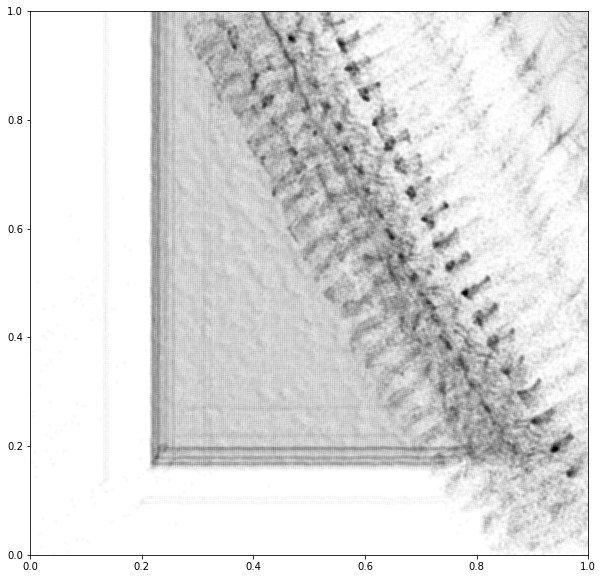

In [40]:
embed.shape
plt.figure(figsize=(10,10))
plt.plot(embed[0,0,:,:,6].detach().cpu().numpy(), embed[0,1,:,:,6].detach().cpu().numpy(),'k.',alpha=0.01)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:




plt.figure(figsize=(10,10))
plt.imshow(ind[0,:,:,10])
plt.show()

In [ ]:
render = out.argmax(1)

In [ ]:
value, ind = out.max(1)

In [ ]:
ind[value<0.5]=0

In [ ]:
ind.cpu().detach().squeeze(0).numpy().min()

In [ ]:
del ind, value

In [ ]:
plt.plot(embed[0,0,:,:,6].detach().cpu().numpy(), embed[0,1,:,:,6].detach().cpu().numpy(),'k.',alpha=0.002)
plt.plot(cent[0,:,0].cpu(), cent[0,:,1].cpu(), 'ro')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()



In [43]:
%%time
model.eval()
with torch.no_grad():
    for data_dict in val:
        image = data_dict['image']
        image = (image - 0.5) / 0.5

        out = model(image.cuda(), 5)
        embed = src.functional.vector_to_embedding(out)
        cent = src.functional.estimate_centroids(embed, 0.01, 100)
        cent = cent.unsqueeze(0)
        cent[:,:,0] *= image.shape[2]
        cent[:,:,1] *= image.shape[3]
        cent[:,:,2] *= 40
        out = src.functional.embedding_to_probability(embed.cpu(), cent.cpu(), torch.tensor([0.0231]))
        break
        
# value, ind = out.max(1)
# ind[value<0.5]=0
# correction_matrix = binary_dilation(binary_erosion(ind))
# ind[np.logical_not(binary_dilation)] = 0
# io.imsave('naieve_test.tif', ind.cpu().detach().squeeze(0).float().numpy().transpose((2,1,0)))
# ind.min()
# ind.shape

CPU times: user 44.3 s, sys: 17.3 s, total: 1min 1s
Wall time: 9.75 s


In [11]:
ind.shape

torch.Size([1, 512, 512, 30])

In [ ]:
%timeit
sigma_list = torch.linspace(0.0, 0.05, 40)
losses = []
loss_fun = src.loss.jaccard_loss()

model.eval()
for i, s in enumerate(sigma_list):
    with torch.no_grad():
        for data_dict in val:
            image = data_dict['image']
            image = (image - 0.5) / 0.5
            mask = data_dict['masks'] > 0.5
            centroids = data_dict['centroids']

            out = model(image.cuda(), 5)
            out = src.functional.vector_to_embedding(out)
            embed = out.cpu()
            out = src.functional.embedding_to_probability(out, centroids.cuda(), s)
            loss = loss_fun(out, mask.cuda())
            losses.append(loss.item())
            print(s, loss.item())
            break
        
model.train()

# plt.plot(sigma_list, losses)
# plt.ylabel('Loss')
# plt.xlabel('Sigma')
# plt.show()
# model.train()
# print(' ')

In [15]:
colors = torch.zeros(image.shape)
for z in range(image.shape[4]):
    print(z)
    for x in range(image.shape[2]):
        for y in range(image.shape[3]):

            if ind[0,x,y,z] == 0:
                continue
            torch.manual_seed(ind[0,x,y,z])
            colors[0,:,x,y,z] = torch.rand(3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [30]:
re = (image[:,[2,1,0],...] + (colors * 0.8))[0,...].numpy().transpose((3,1,2,0))

In [31]:
colors.shape

torch.Size([1, 3, 512, 512, 29])

In [32]:
io.imsave('re.tif',re)